# Using `polars` with `dataframe-haystack`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EdAbati/dataframes-haystack/blob/main/notebooks/polars-example.ipynb)


In [1]:
# when running in Google Colab (or similar), install the following packages
# !pip install 'dataframe-haystack[polars]' arxiv

In [2]:
import polars as pl

## Downloading the dataset

We are using a dataset that contains abstracts of papers uploaded on arXiv. We are using the arXiv API to get the data.

In [3]:
def get_arxiv_data(search_query: str, max_num_rows: int = 10) -> pl.DataFrame:
    """Get data using the arXiv API."""
    import arxiv

    arxiv_client = arxiv.Client()

    search = arxiv.Search(query=search_query, max_results=max_num_rows, sort_by=arxiv.SortCriterion.Relevance)
    results_list = [
        {
            "title": result.title,
            "authors": [author.name for author in result.authors],
            "summary": result.summary,
            "published": result.published,
            "primary_category": result.primary_category,
            "categories": result.categories,
            "pdf_url": result.pdf_url,
            "entry_id": result.entry_id,
        }
        for result in arxiv_client.results(search)
    ]
    return pl.DataFrame(results_list)

We will have a dataset of 10 rows with papers about LLMs.

In [4]:
df = get_arxiv_data("llm", max_num_rows=10)
df.head()

title,authors,summary,published,primary_category,categories,pdf_url,entry_id
str,list[str],str,datetime[μs],str,list[str],str,str
"""Large Language Models as Softw…","[""Irene Weber""]","""Large Language Models (LLMs) h…",2024-06-13 21:32:56,"""cs.SE""","[""cs.SE"", ""cs.CL"", … ""A.1; I.2.7; D.2.11""]","""http://arxiv.org/pdf/2406.1030…","""http://arxiv.org/abs/2406.1030…"
"""Parrot: Efficient Serving of L…","[""Chaofan Lin"", ""Zhenhua Han"", … ""Lili Qiu""]","""The rise of large language mod…",2024-05-30 09:46:36,"""cs.LG""","[""cs.LG"", ""cs.AI""]","""http://arxiv.org/pdf/2405.1988…","""http://arxiv.org/abs/2405.1988…"
"""A Survey of Large Language Mod…","[""Zibin Zheng"", ""Kaiwen Ning"", … ""Jiachi Chen""]","""General large language models …",2023-11-17 07:55:16,"""cs.SE""","[""cs.SE""]","""http://arxiv.org/pdf/2311.1037…","""http://arxiv.org/abs/2311.1037…"
"""A Survey of Large Language Mod…","[""Wenbo Shang"", ""Xin Huang""]","""A graph is a fundamental data …",2024-04-23 07:39:24,"""cs.CL""","[""cs.CL"", ""cs.AI"", ""cs.DB""]","""http://arxiv.org/pdf/2404.1480…","""http://arxiv.org/abs/2404.1480…"
"""TEST: Text Prototype Aligned E…","[""Chenxi Sun"", ""Hongyan Li"", … ""Shenda Hong""]","""This work summarizes two ways …",2023-08-16 09:16:02,"""cs.CL""","[""cs.CL"", ""cs.AI""]","""http://arxiv.org/pdf/2308.0824…","""http://arxiv.org/abs/2308.0824…"


Saving the data in a temporary file.

In [5]:
import tempfile

# create a temporary file
temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".parquet")

# write the dataframe to the temporary file
with open(temp_file.name, "w") as f:
    df.write_parquet(f)

## Loading the data in `haystack`

We can read the data using a `FileToPolarsDataFrame` and convert the rows into `Document`s using a `PolarsDataFrameConverter` component.

In [6]:
from dataframes_haystack.components.converters.polars import FileToPolarsDataFrame, PolarsDataFrameConverter

In [7]:
file_to_polars = FileToPolarsDataFrame(file_format="parquet")

In [8]:
output_dataframe = file_to_polars.run(files=[temp_file.name])

In [9]:
# the output_dataframe is a dictionary with a dataframe key
output_dataframe.keys()

dict_keys(['dataframe'])

In [10]:
output_dataframe["dataframe"].head()

title,authors,summary,published,primary_category,categories,pdf_url,entry_id
str,list[str],str,datetime[μs],str,list[str],str,str
"""Large Language Models as Softw…","[""Irene Weber""]","""Large Language Models (LLMs) h…",2024-06-13 21:32:56,"""cs.SE""","[""cs.SE"", ""cs.CL"", … ""A.1; I.2.7; D.2.11""]","""http://arxiv.org/pdf/2406.1030…","""http://arxiv.org/abs/2406.1030…"
"""Parrot: Efficient Serving of L…","[""Chaofan Lin"", ""Zhenhua Han"", … ""Lili Qiu""]","""The rise of large language mod…",2024-05-30 09:46:36,"""cs.LG""","[""cs.LG"", ""cs.AI""]","""http://arxiv.org/pdf/2405.1988…","""http://arxiv.org/abs/2405.1988…"
"""A Survey of Large Language Mod…","[""Zibin Zheng"", ""Kaiwen Ning"", … ""Jiachi Chen""]","""General large language models …",2023-11-17 07:55:16,"""cs.SE""","[""cs.SE""]","""http://arxiv.org/pdf/2311.1037…","""http://arxiv.org/abs/2311.1037…"
"""A Survey of Large Language Mod…","[""Wenbo Shang"", ""Xin Huang""]","""A graph is a fundamental data …",2024-04-23 07:39:24,"""cs.CL""","[""cs.CL"", ""cs.AI"", ""cs.DB""]","""http://arxiv.org/pdf/2404.1480…","""http://arxiv.org/abs/2404.1480…"
"""TEST: Text Prototype Aligned E…","[""Chenxi Sun"", ""Hongyan Li"", … ""Shenda Hong""]","""This work summarizes two ways …",2023-08-16 09:16:02,"""cs.CL""","[""cs.CL"", ""cs.AI""]","""http://arxiv.org/pdf/2308.0824…","""http://arxiv.org/abs/2308.0824…"


In [11]:
polars_converter = PolarsDataFrameConverter(
    content_column="summary",
    meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
)

In [12]:
polars_converter.run(dataframe=output_dataframe["dataframe"])

{'documents': [Document(id=c4fbde87ad579d0c39ebe835c996dc1b6fee182aca86b1ce71496f1fa970180a, content: 'Large Language Models (LLMs) have become widely adopted recently. Research
  explores their use both a...', meta: {'title': 'Large Language Models as Software Components: A Taxonomy for LLM-Integrated Applications', 'authors': ['Irene Weber'], 'published': datetime.datetime(2024, 6, 13, 21, 32, 56), 'primary_category': 'cs.SE', 'categories': ['cs.SE', 'cs.CL', 'cs.LG', 'A.1; I.2.7; D.2.11'], 'pdf_url': 'http://arxiv.org/pdf/2406.10300v1'}),
  Document(id=3f45abd46d3ffddf3178166b14c95f9efc5926765cd1f874f3ed89c4cfa14152, content: 'The rise of large language models (LLMs) has enabled LLM-based applications
  (a.k.a. AI agents or co-...', meta: {'title': 'Parrot: Efficient Serving of LLM-based Applications with Semantic Variable', 'authors': ['Chaofan Lin', 'Zhenhua Han', 'Chengruidong Zhang', 'Yuqing Yang', 'Fan Yang', 'Chen Chen', 'Lili Qiu'], 'published': datetime.datetime(2024, 5, 30,

If we want to use a column of the dataframe as unique identifier for documents, we can set the `index_column` parameter.

In [13]:
polars_converter = PolarsDataFrameConverter(
    content_column="summary",
    meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
    index_column="entry_id",
)
polars_converter.run(dataframe=output_dataframe["dataframe"])

{'documents': [Document(id=http://arxiv.org/abs/2406.10300v1, content: 'Large Language Models (LLMs) have become widely adopted recently. Research
  explores their use both a...', meta: {'title': 'Large Language Models as Software Components: A Taxonomy for LLM-Integrated Applications', 'authors': ['Irene Weber'], 'published': datetime.datetime(2024, 6, 13, 21, 32, 56), 'primary_category': 'cs.SE', 'categories': ['cs.SE', 'cs.CL', 'cs.LG', 'A.1; I.2.7; D.2.11'], 'pdf_url': 'http://arxiv.org/pdf/2406.10300v1'}),
  Document(id=http://arxiv.org/abs/2405.19888v1, content: 'The rise of large language models (LLMs) has enabled LLM-based applications
  (a.k.a. AI agents or co-...', meta: {'title': 'Parrot: Efficient Serving of LLM-based Applications with Semantic Variable', 'authors': ['Chaofan Lin', 'Zhenhua Han', 'Chengruidong Zhang', 'Yuqing Yang', 'Fan Yang', 'Chen Chen', 'Lili Qiu'], 'published': datetime.datetime(2024, 5, 30, 9, 46, 36), 'primary_category': 'cs.LG', 'categories': ['cs.L

### Using the components in a pipeline

In [14]:
from haystack import Pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

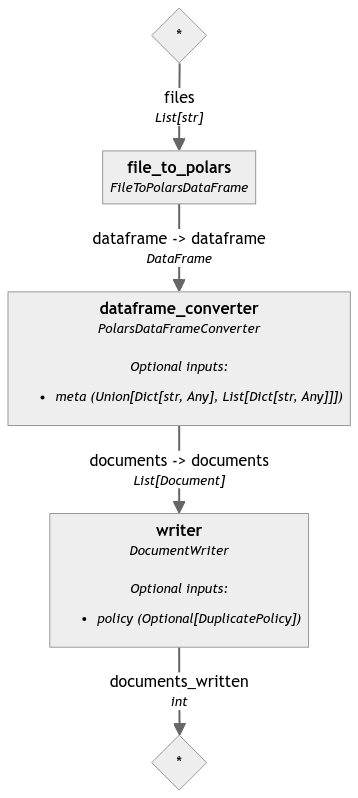

In [15]:
document_store = InMemoryDocumentStore()

indexing = Pipeline()
indexing.add_component("file_to_polars", FileToPolarsDataFrame(file_format="parquet"))
indexing.add_component(
    "dataframe_converter",
    PolarsDataFrameConverter(
        content_column="summary",
        meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
    ),
)
indexing.add_component("writer", DocumentWriter(document_store))
indexing.connect("file_to_polars", "dataframe_converter")
indexing.connect("dataframe_converter", "writer")
indexing.show()

In [16]:
indexing.run({"file_to_polars": {"files": [temp_file.name]}})

{'writer': {'documents_written': 10}}

Saving the data in a temporary file.

In [17]:
# Cleanup
# delete the temporary file
from pathlib import Path

Path(temp_file.name).unlink()